
    # Logical Data Quality Detection with Spark MLlib
    This notebook demonstrates clustering, anomaly detection, and classification using synthetic data to identify aggregator behavior, test data pollution, and classify real vs synthetic users in Microsoft Fabric.
    

In [3]:

    from pyspark.sql import SparkSession
    from pyspark.sql.functions import col

    spark = SparkSession.builder.getOrCreate()

    # Synthetic data: user_id, weekly_purchases, purchase_diversity, geo_dispersion, is_test_user
    data = [
        ("user_001", 1000, 50, 10, 0),
        ("user_002", 5, 1, 1, 0),
        ("user_003", 500, 30, 5, 0),
        ("user_004", 10, 2, 1, 1),
        ("user_005", 800, 40, 8, 0),
        ("user_006", 3, 1, 1, 1),
        ("user_007", 1200, 60, 12, 0),
        ("user_008", 6, 2, 1, 1)
    ]

    columns = ["user_id", "weekly_purchases", "purchase_diversity", "geo_dispersion", "is_test_user"]
    df = spark.createDataFrame(data, columns)
    display(df)
    

StatementMeta(, bc817dc7-52ba-42dc-b86b-634b65b32cf7, 5, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, a7dcef9e-063d-4978-972b-59ea68bc74b2)

In [4]:

    from pyspark.ml.feature import VectorAssembler

    assembler = VectorAssembler(
        inputCols=["weekly_purchases", "purchase_diversity", "geo_dispersion"],
        outputCol="features"
    )
    feature_df = assembler.transform(df)
    

StatementMeta(, bc817dc7-52ba-42dc-b86b-634b65b32cf7, 6, Finished, Available, Finished)

In [5]:

    # Clustering with KMeans
    from pyspark.ml.clustering import KMeans

    kmeans = KMeans(k=2, seed=1, featuresCol="features", predictionCol="cluster")
    model = kmeans.fit(feature_df)
    clustered_df = model.transform(feature_df)
    display(clustered_df.select("user_id", "cluster"))
    

StatementMeta(, bc817dc7-52ba-42dc-b86b-634b65b32cf7, 7, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, b034a96c-8b56-4269-8d41-e0be012cf1eb)

In [6]:

    # Anomaly Detection using distance from cluster center
    from pyspark.sql.functions import udf
    from pyspark.ml.linalg import Vectors, DenseVector
    from pyspark.sql.types import DoubleType

    centers = model.clusterCenters()

    def compute_distance(features, cluster):
        center = DenseVector(centers[cluster])
        return float(Vectors.squared_distance(features, center))

    distance_udf = udf(compute_distance, DoubleType())
    clustered_df = clustered_df.withColumn("anomaly_score", distance_udf(col("features"), col("cluster")))
    display(clustered_df.select("user_id", "cluster", "anomaly_score"))
    

StatementMeta(, bc817dc7-52ba-42dc-b86b-634b65b32cf7, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 16801b54-1d25-47e8-b36c-0d7e0c3d1ad7)

In [39]:

    # Classification: Predicting test users
    from pyspark.ml.classification import LogisticRegression

    classifier_df = clustered_df.select("features", "is_test_user")

    lr = LogisticRegression(featuresCol="features", labelCol="is_test_user", predictionCol="prediction")
    lr_model = lr.fit(classifier_df)
    predictions = lr_model.transform(classifier_df)
    display(predictions.select("features", "is_test_user", "prediction"))
    display(predictions)
    

StatementMeta(, bc817dc7-52ba-42dc-b86b-634b65b32cf7, 48, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, c8e4adb0-960d-4f88-a3bc-baad6d43805f)

SynapseWidget(Synapse.DataFrame, 9615a580-4324-40f5-ac71-29793eb689ee)

In [36]:
%%sql

-- DROP TABLE lk_cdsa_silver.silver_db.logical_quality_results;
 
CREATE TABLE IF NOT EXISTS silver_db.logical_quality_results (
    features ARRAY<DOUBLE>,
    is_test_user BIGINT,
    rawPrediction ARRAY<DOUBLE>,
    probability ARRAY<DOUBLE>,
    prediction DOUBLE
)
USING DELTA;


SHOW TABLES IN lk_cdsa_silver.silver_db;

StatementMeta(, bc817dc7-52ba-42dc-b86b-634b65b32cf7, 45, Finished, Available, Finished)

<Spark SQL result set with 0 rows and 0 fields>

<Spark SQL result set with 1 rows and 3 fields>

In [ ]:
#spark.sql("DROP TABLE IF EXISTS lk_cdsa_silver.silver_db.logical_quality_results_v2")
display(predictions);
predictions.printSchema();

predictions = predictions.withColumn("features", df["features"].toArray())
predictions = predictions.withColumn("rawPrediction", df["rawPrediction"].toArray())
predictions = predictions.withColumn("probability", df["probability"].toArray())

predictions.write.format("delta").mode("overwrite").saveAsTable("lk_cdsa_silver.silver_db.logical_quality_results");

#display(spark.sql(f"""
#            SELECT * 
#            FROM lk_cdsa_silver.silver_db.logical_quality_results
#        """))


In [11]:
%%sql

delete from lk_cdsa_bronze.bronze_db.stg_cdtq_customer_0000001 where last_name = 'Doe';
insert into lk_cdsa_bronze.bronze_db.stg_cdtq_customer_0000001
select 999 as customer_id, 'Mickey' as first_name, 'Mouse' as last_name, '123 Test St' as street_address, 'Anywhere' as city, 'California' as state_prov, '12345' as postal, 'XYZ Inc' as company, 'Tech Lead' as job, 'jdoe@test.com' as email, 12345 as random_number, '3153eccd-3210-6d0c-596d-caf474c790bb' as guid, '70.195.131.113' as ipv4, '123-456-7890' as phone, '1900-01-01' as dob, 'test' as origin;

select * from lk_cdsa_bronze.bronze_db.stg_cdtq_customer_0000001;


StatementMeta(, 28cc2531-a52a-436f-9325-9bd5713a00c9, 18, Finished, Available, Finished)

<Spark SQL result set with 1 rows and 1 fields>

<Spark SQL result set with 0 rows and 0 fields>

<Spark SQL result set with 501 rows and 16 fields>

StatementMeta(, ea9c8db5-de57-4e33-b13a-82044095db8f, 12, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, eb8a0445-9cf0-4c67-8fda-6fb60f2111ce)

Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1 Score: 1.0000
Test AUC Score: 1.0000


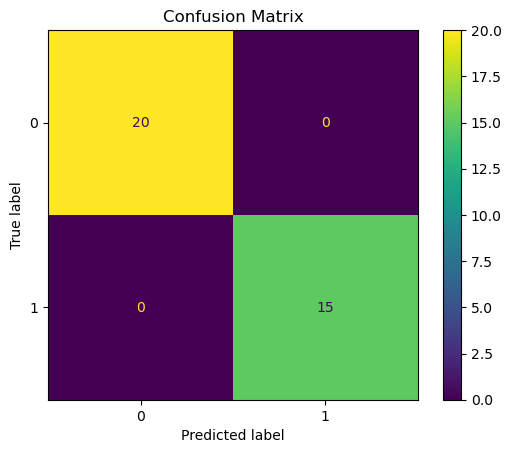

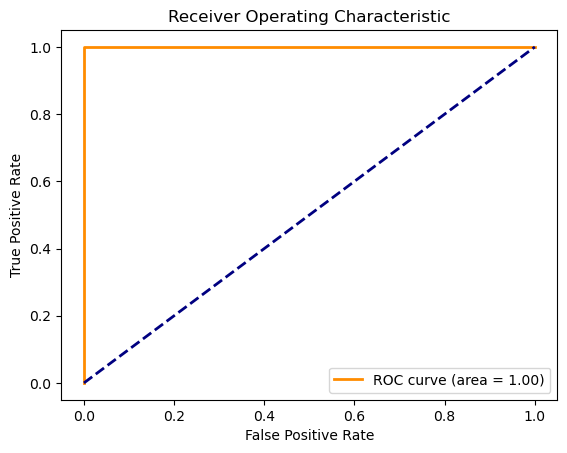

SynapseWidget(Synapse.DataFrame, f98fcfd7-b139-4be6-87df-76020d2a4775)

In [10]:

# PySpark MLlib Notebook: Detecting Test or Synthetic Customers

# This notebook trains a logistic regression model using PySpark MLlib to detect synthetic or test customers
# based on known placeholder patterns in fields like email, phone, name, DOB, address, zip code, and company name.
# It evaluates the model using accuracy, precision, recall, F1 score, and AUC, and visualizes the confusion matrix and ROC curve.

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, lit, struct, when, udf, format_number
from pyspark.ml.feature import VectorAssembler, StringIndexerModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from pyspark.sql.types import DoubleType, StringType
import matplotlib.pyplot as plt
import numpy as np

# Initialize Spark session
spark = SparkSession.builder.getOrCreate()

# Load enriched labeled dataset
# This dataset should include columns like first_name, last_name, email, phone, date_of_birth, address, zip_code, company_name, and label
#df = spark.read.option("header", True).option("inferSchema", True).csv("abfss://CDSA@onelake.dfs.fabric.microsoft.com/lk_cdsa_landing_zone.Lakehouse/Files/ml_training_data/customer_data/enriched_labeled_customer_data.csv")
df = spark.read.option("header", True).option("inferSchema", True).csv("abfss://CDSA@onelake.dfs.fabric.microsoft.com/lk_cdsa_landing_zone.Lakehouse/Files/ml_training_data/customer_data/synthetic_customer_test_data.csv")

# Define synthetic patterns
email_indicators = ["test", "admin", "null", "spamtrap", "example", "private", "none", "xyz"]
phone_indicators = ["9876543210", "911", "411", "5550101234", "0", "0000000000"]
name_indicators = ["test", "demo", "sample", "null", "placeholder", "mickey", "mouse"]
dob_indicators = ["1900-01-01", "1/1/1900"]
address_indicators = ["123 test st", "unknown", "n/a", "null", "fake", "placeholder"]
zip_indicators = ["00000", "12345", "99999"]
company_indicators = ["test", "demo", "sample", "unknown", "n/a", "null"]

# Create indicator flags
df = df.withColumn("email_flag", when(lower(col("email")).rlike("(" + "|".join(email_indicators) + ")"), 1).otherwise(0))
df = df.withColumn("phone_flag", when(col("phone").isin(phone_indicators), 1).otherwise(0))
df = df.withColumn("name_flag", when(lower(col("first_name")).rlike("(" + "|".join(name_indicators) + ")") |
                                      lower(col("last_name")).rlike("(" + "|".join(name_indicators) + ")"), 1).otherwise(0))
df = df.withColumn("dob_flag", when(col("date_of_birth").isin(dob_indicators), 1).otherwise(0))
df = df.withColumn("address_flag", when(lower(col("address")).rlike("(" + "|".join(address_indicators) + ")"), 1).otherwise(0))
df = df.withColumn("zip_flag", when(col("zip_code").isin(zip_indicators), 1).otherwise(0))
df = df.withColumn("company_flag", when(lower(col("company_name")).rlike("(" + "|".join(company_indicators) + ")"), 1).otherwise(0))

# Add synthetic_score feature
df = df.withColumn("synthetic_score", col("email_flag") + col("phone_flag") + col("name_flag") +
                   col("dob_flag") + col("address_flag") + col("zip_flag") + col("company_flag"))

# Correct label mapping: real = 0, synthetic = 1
df = df.withColumn("indexed_label", when(col("label") == 0, 0).otherwise(1))

# Assemble features
assembler = VectorAssembler(
    inputCols=["email_flag", "phone_flag", "name_flag", "dob_flag", "address_flag", "zip_flag", "company_flag", "synthetic_score"],
    outputCol="features"
)

# Logistic Regression with adjusted threshold
lr = LogisticRegression(featuresCol="features", labelCol="indexed_label", predictionCol="prediction",
                        probabilityCol="probability", threshold=0.3)

# Build pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Split and train
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)
model = pipeline.fit(train_df)

# Save model after training
model.write().overwrite().save("abfss://CDSA@onelake.dfs.fabric.microsoft.com/lk_cdsa_landing_zone.Lakehouse/Files/ml_models/sythetic_customer_logistic_model")

# Apply model
predictions = model.transform(df)
predictions = predictions.withColumn("is_real_customer", when(col("prediction") == 0, lit("Y")).otherwise(lit("N")))

# Extract prediction and confidence
extract_confidence = udf(lambda v: f"{float(v[0]):.10f}", StringType())
predictions = predictions.withColumn("is_real_customer", when(col("prediction") == 0, lit("Y")).otherwise(lit("N")))
predictions = predictions.withColumn("confidence", extract_confidence(col("probability")))
predictions = predictions.withColumn("real_customer_probability", struct(col("is_real_customer"), col("confidence")))

# Convert confidence to score between 0.00 and 10.00
predictions = predictions.withColumn("real_customer_score", format_number((col("confidence") * 10), 2))

# Show results
display(predictions.select(
    "first_name", "last_name", "email", "phone", "date_of_birth", "address", "zip_code",
    "company_name", "is_real_customer", "confidence", "real_customer_score"
))


# Evaluate model on test set
predictions_test = model.transform(test_df)
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="f1")
evaluator_auc = BinaryClassificationEvaluator(labelCol="indexed_label", rawPredictionCol="probability", metricName="areaUnderROC")
accuracy = evaluator_accuracy.evaluate(predictions_test)
precision = evaluator_precision.evaluate(predictions_test)
recall = evaluator_recall.evaluate(predictions_test)
f1_score = evaluator_f1.evaluate(predictions_test)
auc_score = evaluator_auc.evaluate(predictions_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")
print(f"Test AUC Score: {auc_score:.4f}")

# Visualize confusion matrix
y_true = predictions_test.select("indexed_label").rdd.flatMap(lambda x: x).collect()
y_pred = predictions_test.select("prediction").rdd.flatMap(lambda x: x).collect()
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix")
plt.show()

# Visualize ROC curve
y_score = predictions_test.select("probability").rdd.map(lambda x: x[0][1]).collect()
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#-------------------------------------------------------
# Score new customer data
#-------------------------------------------------------
# Load new customer data from Delta table
new_df = spark.read.format("delta").load("abfss://CDSA@onelake.dfs.fabric.microsoft.com/lk_cdsa_bronze.Lakehouse/Tables/bronze_db/stg_cdtq_customer_0000001")

# Select and rename columns
new_df = new_df.select(
    col("first_name"),
    col("last_name"),
    col("email"),
    lit("").alias("phone"),  # placeholder since phone is missing
    col("dob").alias("date_of_birth"),
    col("street_address").alias("address"),
    col("postal").alias("zip_code"),
    col("company").alias("company_name")
)

#display(new_df)

# Create indicator flags
new_df = new_df.withColumn("email_flag", when(lower(col("email")).rlike("(" + "|".join(email_indicators) + ")"), 1).otherwise(0))
new_df = new_df.withColumn("phone_flag", when(col("phone").isin(phone_indicators), 1).otherwise(0))
new_df = new_df.withColumn("name_flag", when(lower(col("first_name")).rlike("(" + "|".join(name_indicators) + ")") |
                                      lower(col("last_name")).rlike("(" + "|".join(name_indicators) + ")"), 1).otherwise(0))
new_df = new_df.withColumn("dob_flag", when(col("date_of_birth").isin(dob_indicators), 1).otherwise(0))
new_df = new_df.withColumn("address_flag", when(lower(col("address")).rlike("(" + "|".join(address_indicators) + ")"), 1).otherwise(0))
new_df = new_df.withColumn("zip_flag", when(col("zip_code").isin(zip_indicators), 1).otherwise(0))
new_df = new_df.withColumn("company_flag", when(lower(col("company_name")).rlike("(" + "|".join(company_indicators) + ")"), 1).otherwise(0))

# Add synthetic_score
new_df = new_df.withColumn("synthetic_score",
    col("email_flag") + col("phone_flag") + col("name_flag") +
    col("dob_flag") + col("address_flag") + col("zip_flag") + col("company_flag"))

# Load trained model
model = PipelineModel.load("abfss://CDSA@onelake.dfs.fabric.microsoft.com/lk_cdsa_landing_zone.Lakehouse/Files/ml_models/sythetic_customer_logistic_model")

# Apply model
predictions = model.transform(new_df)

# Extract prediction and confidence
extract_confidence = udf(lambda v: f"{float(v[0]):.10f}", StringType())
predictions = predictions.withColumn("is_real_customer", when(col("prediction") == 0, lit("Y")).otherwise(lit("N")))
predictions = predictions.withColumn("confidence", extract_confidence(col("probability")))
predictions = predictions.withColumn("real_customer_probability", struct(col("is_real_customer"), col("confidence")))

# Convert confidence to score between 0.00 and 10.00
predictions = predictions.withColumn("real_customer_score", format_number((col("confidence") * 10), 2))

# Show results
display(predictions.select(
    "first_name", "last_name", "email", "phone", "date_of_birth", "address", "zip_code",
    "company_name", "is_real_customer", "confidence", "real_customer_score"
))
